# Your mission

You started working in a financial institution. You manager Mark is insterested in investing and trading **Bitcoin** to diversify his portfolio. So he turned to you to develop a crypto trading bot.

A **crypto trading bot** is a computer program with an underlying predictive model that automatically outputs a predicted day to day price for the next 30 days based on the history of Bitcoin market price and Blockchain variables. 

Your mission is to train an accurate predictive model with the lowest mean squared error. Mark is a very technical guy, he likes to understand all **technical details** and would like you to **compare the performances of classical models and neural-net based models**.

Your **target variable** is the Bitcoin Market price.

**Data source** : https://blockchain.info/

In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import scipy
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import helper_functions as hf

CURDIR = os.path.dirname(os.getcwd())
DATADIR = os.path.join(CURDIR,  "data")
%matplotlib inline

# Data Exploration

In this section, you are to explore the data. You are to fulfill the following tasks:
- **Univariate analysis**
    - study the Bitcoin market price time series, in terms of its trend, cycle, seasonality, and stationnarity 
    - **Tips**: you can analyse ACF, PACF plots, perform Augmented Dickey-Fuller test
- **Multivariate analysis**
    - study other blockchain variables, retrieve insights
    - study the correlation between the Bitcoin market price and other blockchain variables 
    - **Tips**: Pearson correlation

## Univariate analysis

In [33]:
df_blockchain = pd.read_csv(os.path.join(DATADIR, "df_blockchain.csv"), 
                            delimiter=",")


In [34]:
df_blockchain.head()

,Date,market-price,n-transactions-per-block,median-confirmation-time,hash-rate,difficulty,miners-revenue,trade-volume,blocks-size,avg-block-size,...,cost-per-transaction,n-unique-addresses,n-transactions,n-transactions-total,n-transactions-excluding-popular,output-volume,estimated-transaction-volume,estimated-transaction-volume-usd,total-bitcoins,market-cap
0,2011-09-13,6.88,45.908451,0.0,12.018816,1.777774e+06,52318.011503,0.0,592.190091,0.019009,...,7.666766,12622.0,6519.0,1497195.0,6519.0,358543.612114,58615.641320,403275.612279,7.257416e+06,5.022014e+07
1,2011-09-14,6.19,42.465753,0.0,13.263925,1.755425e+06,48306.468911,0.0,594.907367,0.018007,...,7.369408,12408.0,6200.0,1503780.0,6200.0,302619.024544,74521.484625,461287.989830,7.264662e+06,4.540930e+07
2,2011-09-15,5.92,41.500000,0.0,12.914875,1.755425e+06,60431.444952,0.0,597.554226,0.018240,...,7.333913,12988.0,6474.0,1509972.0,6474.0,299226.130646,79422.402932,470180.625359,7.272284e+06,4.322228e+07
3,2011-09-16,5.58,52.176471,0.0,10.995096,1.755425e+06,34345.021913,0.0,600.362512,0.022136,...,5.466341,12059.0,6209.0,1516381.0,6209.0,674606.861338,82696.853247,461448.441118,7.279040e+06,4.088136e+07
4,2011-09-17,5.18,40.701493,0.0,10.733308,1.755425e+06,36805.913687,0.0,602.995510,0.017116,...,6.489054,10988.0,5454.0,1522600.0,5454.0,354198.945778,68238.166521,353473.702578,7.285375e+06,3.801833e+07


In [35]:
df_blockchain.columns.sort_values().shape

(23,)

### Plotting the data

In [36]:
date=df_blockchain["Date"]
temps=[i for i in range(len(np.array(date)))]
prix=df_blockchain["market-price"]

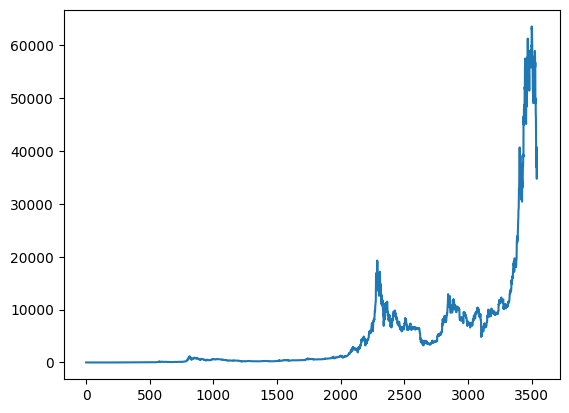

In [37]:
plt.plot(temps,np.array(prix))

The trend seems to be relevent mostly after day 2000 (Roughly the year 2013)

Text(0.5, 1.0, 'Relevent part')

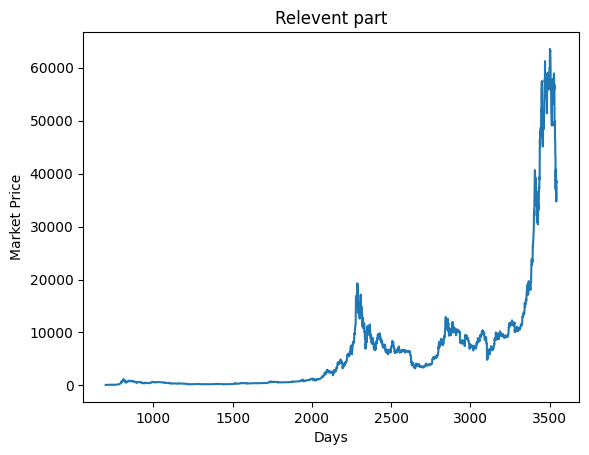

In [38]:
plt.plot(temps[700:],np.array(prix)[700:])
plt.xlabel("Days")
plt.ylabel("Market Price")
plt.title("Relevent part")

### Cycles

Text(0.5, 1.0, 'First Cycle')

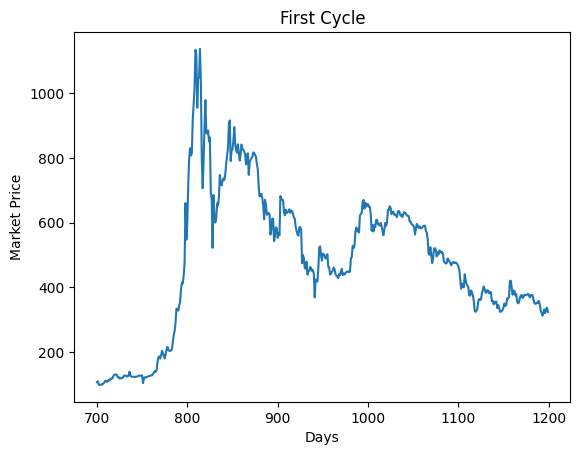

In [39]:
plt.plot(temps[700:1200],np.array(prix)[700:1200])
plt.xlabel("Days")
plt.ylabel("Market Price")
plt.title("First Cycle")

Text(0.5, 1.0, 'Second Cycle')

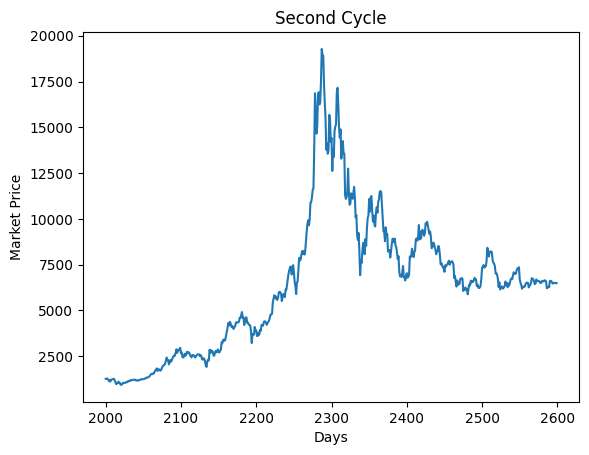

In [40]:
plt.plot(temps[2000:2600],np.array(prix)[2000:2600])
plt.xlabel("Days")
plt.ylabel("Market Price")
plt.title("Second Cycle")

Text(0.5, 1.0, 'Third Cycle')

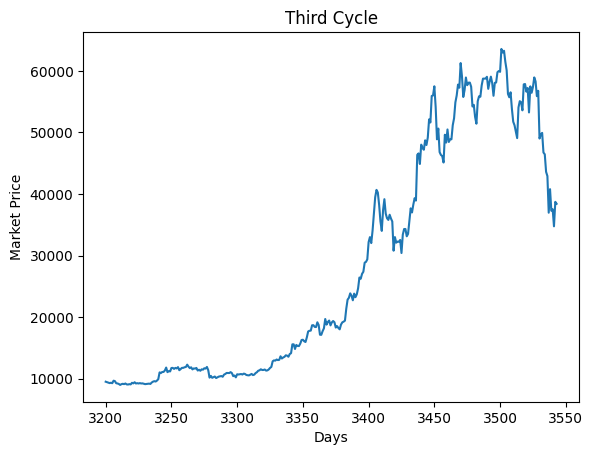

In [41]:
plt.plot(temps[3200:],np.array(prix)[3200:])
plt.xlabel("Days")
plt.ylabel("Market Price")
plt.title("Third Cycle")

There seems to be 3 cycles but however the courb isn't stationnary and there seems to be no seasonality due to the period between cycles beeing different.

### Autocorrelation and Partial correlation

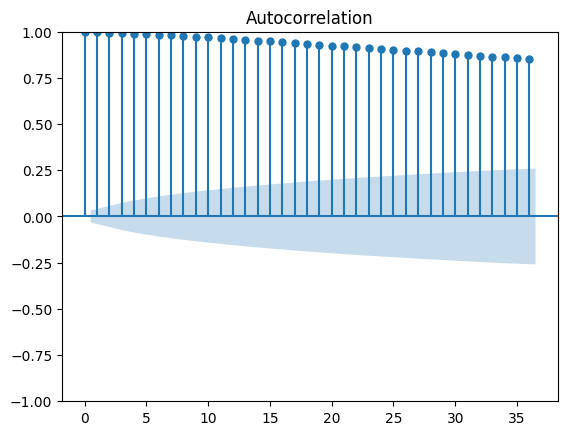

In [42]:
plot_acf(df_blockchain["market-price"]);

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


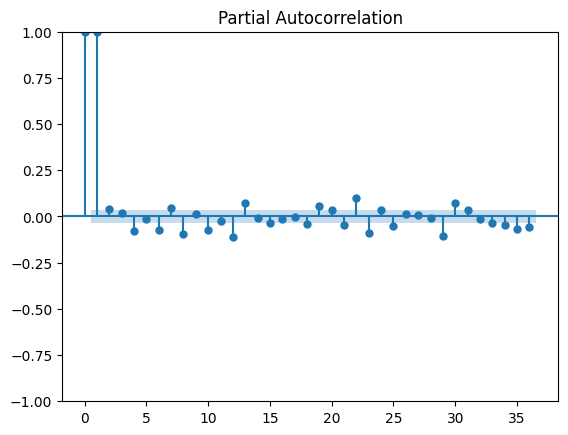

In [43]:
plot_pacf(df_blockchain["market-price"]);

With these graphics, we can conclude that an MA model isn't possible, we could use an AR(1) but a more complex one such as ARMA, ARIMA or ARIMAX seems ideal.

# Differential

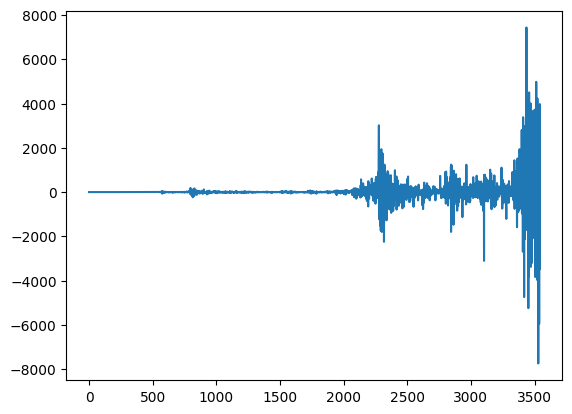

In [44]:
diff1=[]
X=df_blockchain["market-price"].values
for i in range(1,len(X)):
    diff1.append(X[i]-X[i-1])
plt.plot(diff1);

In [45]:
newresult= adfuller(diff1)
print('ADF Statistic: %f' % newresult[0])
print('p-value: %f' % newresult[1])
print('Critical Values:')
for key, value in newresult[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.540725
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


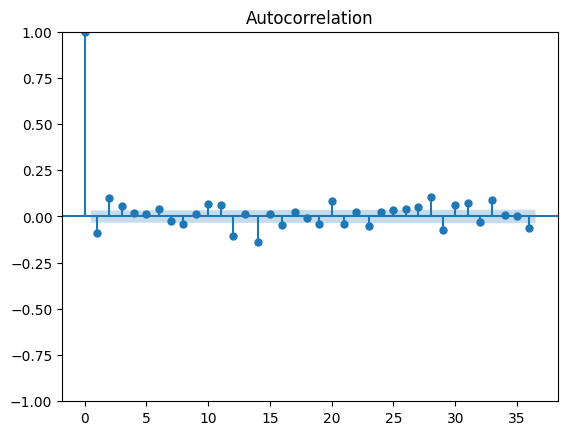

In [46]:
diff1=np.array(diff1)
plot_acf(diff1);

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


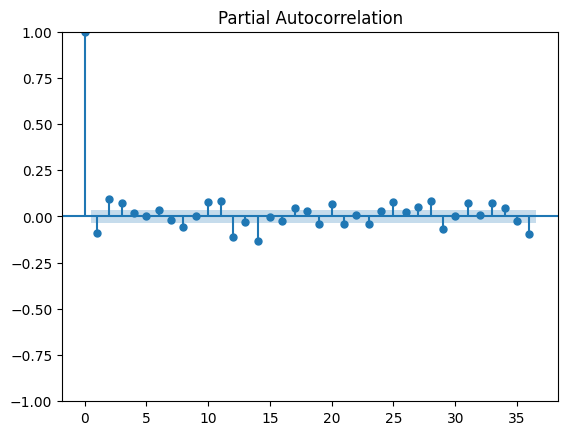

In [47]:
plot_pacf(diff1);

### Dickey Fuller Test for AR(1)


In [48]:
result = adfuller(prix, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -0.5152297946329031
n_lags: 0.8890100827558739
p-value: 0.8890100827558739
Critial Values:
   1%, -3.4322128194388357
Critial Values:
   5%, -2.8623630880962465
Critial Values:
   10%, -2.567208143922995


The p-value is much more than 0.05. We can reject the AR(1) model without hesitation.

## Multivariate analysis

### Study blockchain variables with Pearson correlation

/var/folders/s2/myvbmwhd6_q3sbxkqwg5whp80000gn/T/ipykernel_18345/3189756971.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_blockchain.corr(), cmap='seismic', annot=True, ax=ax)


<AxesSubplot: >

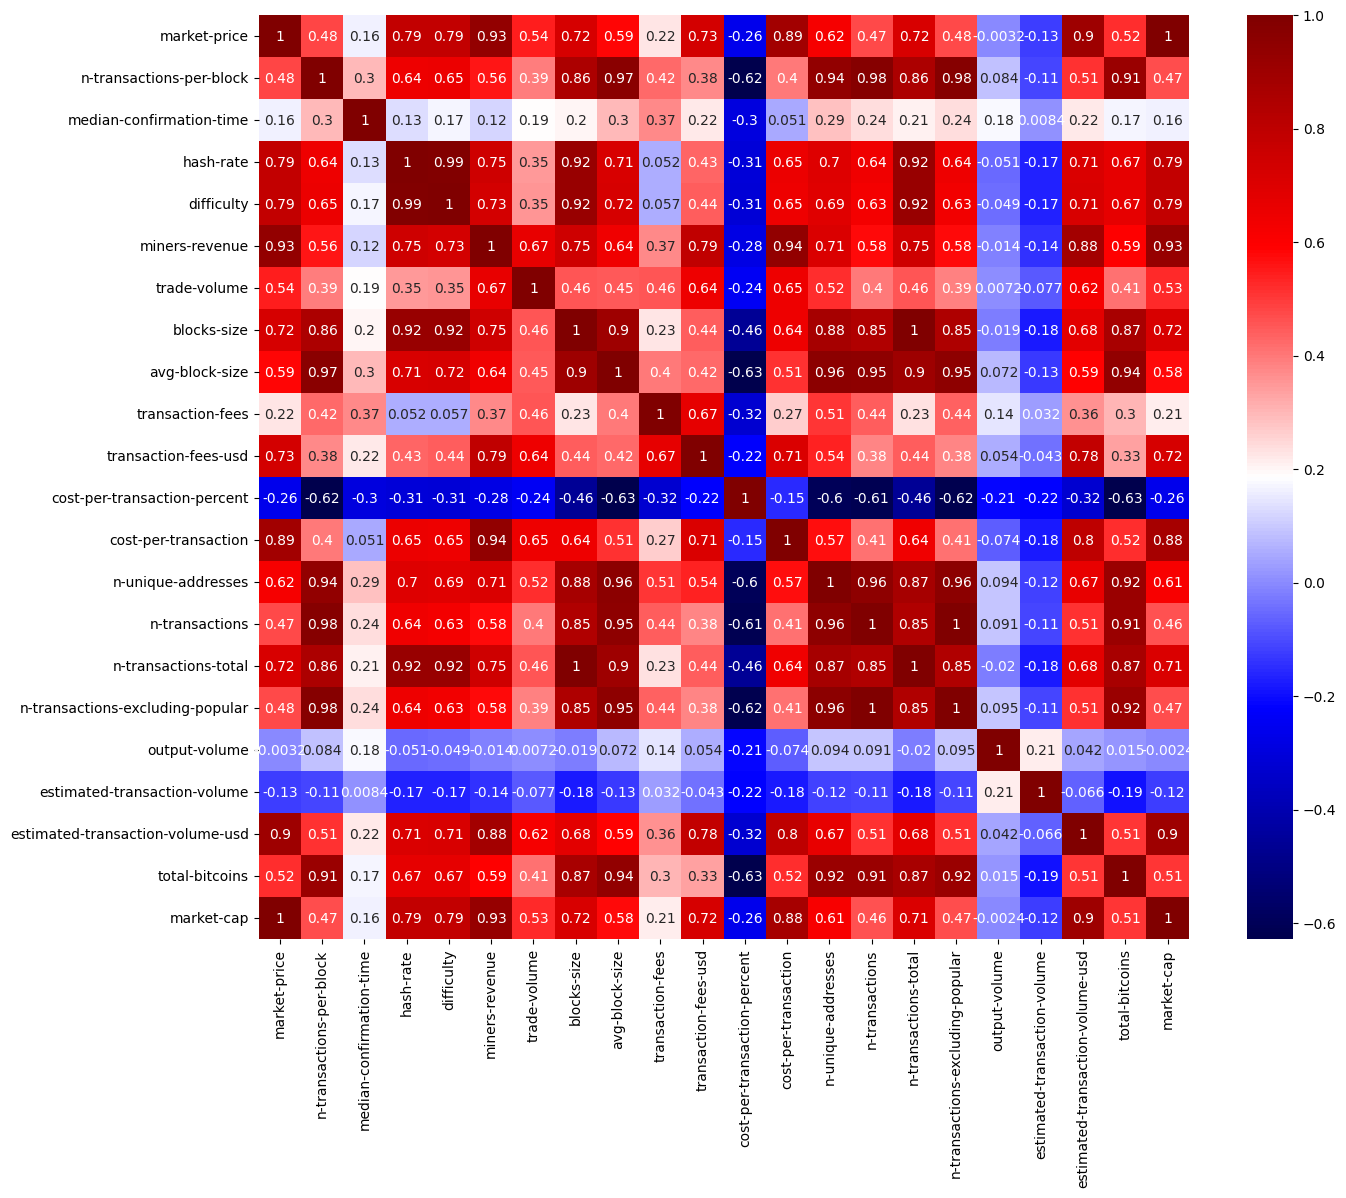

In [49]:
#Pearson Correlation of the variables
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(df_blockchain.corr(), cmap='seismic', annot=True, ax=ax)

On voit que le prix du marché est négativement corrélé avec le cout des transactions (en %). Parrallèlement, c'est très positivement corrélé avec le revenu des mineurs et le volume des transactions estimés. (USD)

### Study the correlation

On a trouvé les 3 paramètres les plus corrélé, donc les plus significatif pour prédire, c'est ceux qu'on pourrait utiliser pour le arimax et le multivariate rnn. On va donc les étudier 

Text(0.5, 1.0, 'R^2 = 0.87')

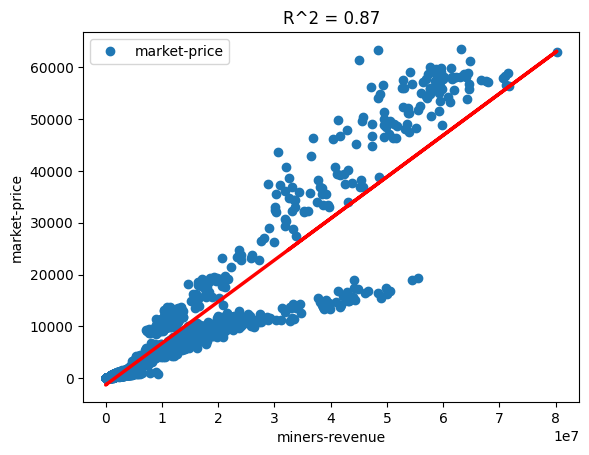

In [50]:
###Miner-Revenue

X = df_blockchain["miners-revenue"][:-1]
X = sm.add_constant(X)
y = df_blockchain["market-price"][:-1]

ols = sm.OLS(y, X).fit()
ols.summary()


fig = df_blockchain.plot(x="miners-revenue", y="market-price", style="o")
fig.set_ylabel("market-price")
ypred = ols.predict(X)
fig.plot(df_blockchain['miners-revenue'][:-1], ypred, 'r', linewidth=2.5)
fig.set_title('R^2 = {:.2f}'.format(ols.rsquared))

Text(0.5, 1.0, 'R^2 = 0.82')

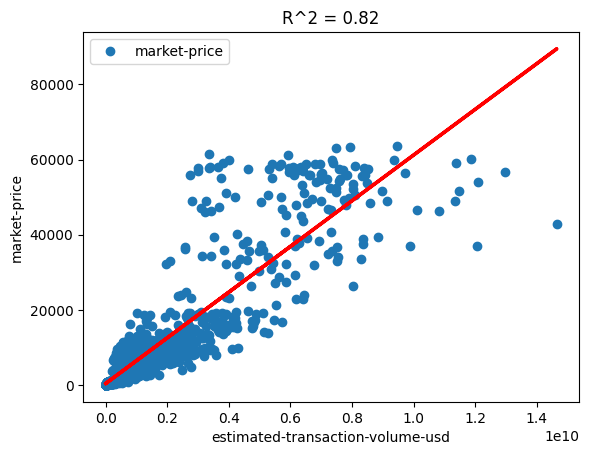

In [51]:
###Estimated-transaction-volume

X = df_blockchain["estimated-transaction-volume-usd"][:-1]
X = sm.add_constant(X) 
y = df_blockchain["market-price"][:-1]

ols = sm.OLS(y, X).fit()
ols.summary()

fig = df_blockchain.plot(x="estimated-transaction-volume-usd", y="market-price", style="o")
fig.set_ylabel("market-price")
ypred = ols.predict(X)
fig.plot(df_blockchain['estimated-transaction-volume-usd'][:-1], ypred, 'r', linewidth=2.5)
fig.set_title('R^2 = {:.2f}'.format(ols.rsquared))

Text(0.5, 1.0, 'R^2 = 0.78')

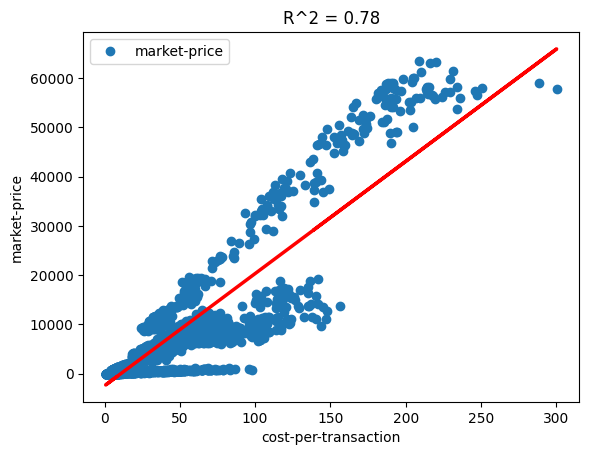

In [52]:
###Cost-per-transaction

X = df_blockchain["cost-per-transaction"][:-1]
X = sm.add_constant(X) 
y = df_blockchain["market-price"][:-1]

ols = sm.OLS(y, X).fit()
ols.summary()

fig = df_blockchain.plot(x="cost-per-transaction", y="market-price", style="o")
fig.set_ylabel("market-price")
ypred = ols.predict(X)
fig.plot(df_blockchain['cost-per-transaction'][:-1], ypred, 'r', linewidth=2.5)
fig.set_title('R^2 = {:.2f}'.format(ols.rsquared))

L'analyse sera faite oralement, mais on peut voir que les deux premiers semblent intéressants pour le ARIMAX et le RNN.

## Train test split

In [53]:
X_train, X_test = hf.data_split(df_blockchain)

# Modeling with ARIMA
In this section, you are to perform some classical modelings, the suggested method here is ARIMA, but you can try other models such as ARMA, ARIMAX, SARIMAX...

## Modeling
The following code allows ARIMA modeling with one combination of (p,d,q).

In [54]:
#If you need information about the function, you can display the docstring
hf.evaluate_arima_model?

Signature: hf.evaluate_arima_model(X_train, X_test, arima_order)
Docstring:
Train, predict and evaluate ARIMA model

Arguments:
----------
- X_train: numpy array
    - train set
- X_test: numpy array
    - test set
- arima_order: tuple
    - (p,d,q)

Returns:
--------
- error: float
    - RMSE
- predictions: numpy array
    - output predictions
File:      ~/Desktop/Ancien_PC/1A/EI_ST4/st4-mds/notebook/helper_functions.py
Type:      function


In [55]:
parameters = (2,1,1)
errors, predictions = hf.evaluate_arima_model(X_train["market-price"], 
                                              X_test["market-price"], parameters )
errors

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


## Search for the best ARIMA model
We use grid search to search for the best ARIMA parameters that gives the lowest error. This follows the Box-Jenkins methology.

In [ ]:
best_cfg, best_score = hf.arima_grid_search(X_train["market-price"], 
                                            X_test["market-price"],
                                            np.arange(1,3), np.arange(3), np.arange(3))

/Users/pierrerighenzi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
/Users/pierrerighenzi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
/Users/pierrerighenzi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
ARIMA(1,0,0) RMSE=2928.575
ARIMA(1,1,0) RMSE=2894.000
ARIMA(1,1,1) RMSE=2885.646
ARIMA(1,1,2) RMSE=2853.038
ARIMA(1,2,0) RMSE=3400.846
/Users/pierrerighenzi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization fai

## Seasonal Decomposition

On vérifie la saisonnalité pour pouvoir utiliser Sarimax

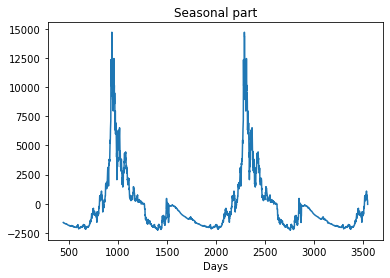

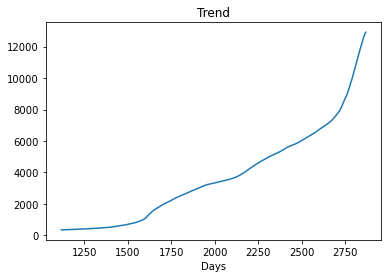

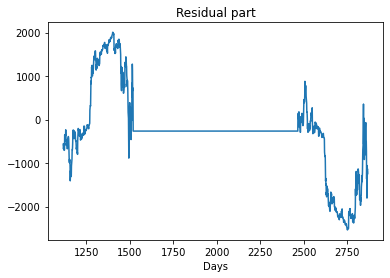

In [ ]:


decomposition = seasonal_decompose(df_blockchain["market-price"][442:], model='additive', period=1350)

season = decomposition.seasonal
trend = decomposition.trend
resid = decomposition.resid

time = np.linspace(0, len(df_blockchain["market-price"])-1, len(df_blockchain["market-price"]))
plt.plot(time[442:], season)
plt.title('Seasonal part')
plt.xlabel('Days')
plt.show()

plt.plot(time[442:], trend)
plt.title('Trend')
plt.xlabel('Days')
plt.show()

plt.plot(time[442:], resid)
plt.title('Residual part')
plt.xlabel('Days')
plt.show()

Les résidus nous montrent clairement l'impossibilité d'utilisation de ce modèle

# ARIMA

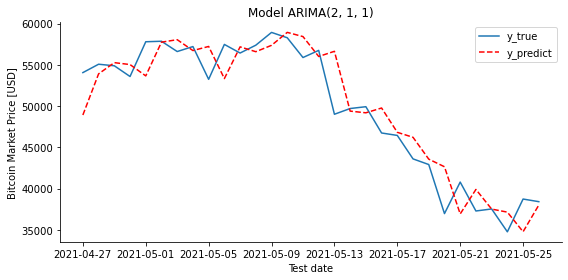

In [ ]:
predict_date = df_blockchain.iloc[-30::]["Date"]
df_predict = pd.DataFrame(zip(predict_date,
                              predictions, X_test["market-price"].values),
                          columns=["date", "predict", "true"])

fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x="date", y="true", data=df_predict, 
             ax=ax, label="y_true", markers=True )
plot_ = sns.lineplot(x="date",
             y="predict",
             data=df_predict,
             color="red",ax=ax, label="y_predict")
plot_.lines[1].set_linestyle("--")
new_ticks = plot_.get_xticklabels()
freq = 4
ax.set_xticks(np.arange(0, len(new_ticks), freq))
labels = predict_date[::freq]
ax.set_xticklabels(labels)
ax.set_ylabel("Bitcoin Market Price [USD]")
ax.set_xlabel("Test date")
ax.set_title(f"Model ARIMA{parameters}")
sns.despine()
plt.legend()
plt.tight_layout()


# ARIMAX

In [ ]:
liste_colonne=df_blockchain.columns.to_list()

a=df_blockchain.dropna(0)
pearson=[]
for i in range(0,len(liste_colonne)):
    pearson.append((scipy.stats.pearsonr(a["market-price"], a[liste_colonne[i]])[0],liste_colonne[i]))

b=pd.DataFrame(pearson,columns=["correlation coeff",'variable'])
b

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

In [ ]:
a=X_test.dropna(0)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def ARIMAX_pred(p,q):
    history = [x for x in X_train]
    # make predictions
    predictions = list()
    for t in range(len(X_test)-1):
        model = SARIMAX(X_train["market-price"],order=(p,1,q),seasonal_order=(0,0,0,0),exog=X_train['market-cap'])
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast(1, exog=a['market-cap'].values[t])
        predictions.append(yhat.values)
        history.append(X_test.values[t])
    return(rmse(a['market-price'], predictions))

In [ ]:
best_param=(0,0)
best_error = 100000000
liste_pred=[]
for i in range(4):
    for j in range(4):
        liste_pred.append([(i,j),ARIMAX_pred(i,j)])
        if liste_pred[-1][1]<best_error:
            best_param=(i,j)
            best_error=liste_pred[-1][1]
result=pd.DataFrame(liste_pred)
result

pierrerighenzi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/pierrerighenzi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/pierrerighenzi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/pierrerighenzi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/pierrerighen

,0,1
0,"(0, 0)",3429.173775
1,"(0, 1)",2150.787615
2,"(0, 2)",2180.701208
3,"(0, 3)",2188.927038
4,"(1, 0)",2473.077746
5,"(1, 1)",2186.426862
6,"(1, 2)",2178.444533
7,"(1, 3)",2190.446666
8,"(2, 0)",2235.422158
9,"(2, 1)",2199.363096


In [ ]:
def predict_arimax(p,d,q,columns):
    history = [x for x in X_train]
    indicateur_train=X_train[columns]
    indicateur_test=X_test[columns]
    indicateur_test=indicateur_test.dropna(0)
    indicateur_train=indicateur_train.dropna(0)
    predictions = list()
    for t in range(len(X_test)-1):
        model = SARIMAX(X_train["market-price"],order=(p,d,q),seasonal_order=(0,0,0,0),exog=indicateur_train)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast(1, exog=indicateur_test.values[t])
        predictions.append(yhat.values)
        history.append(X_test.values[t])
    predict_final=[]
    for i in range(len(predictions)):
        predict_final.append(predictions[i][0])
    return (predict_final,rmse(predict_final,X_test['market-price'][:-1]))

In [ ]:
result=predict_arimax(1,1,0,['miners-revenue'])
df_predict = pd.DataFrame(zip(predict_date,
                              result[0], X_test["market-price"].values),
                          columns=["date", "predict", "true"])
print("error:",result[1])

error: 7019.553540489722


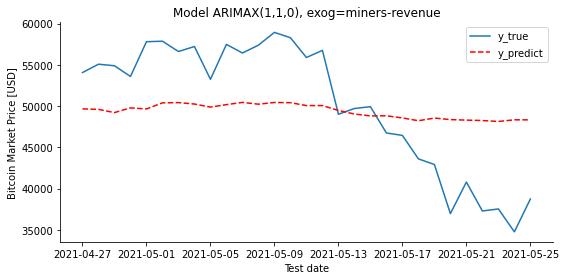

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x="date", y="true", data=df_predict, 
             ax=ax, label="y_true", markers=True )
plot_ = sns.lineplot(x="date",
             y="predict",
             data=df_predict,
             color="red",ax=ax, label="y_predict")
plot_.lines[1].set_linestyle("--")
new_ticks = plot_.get_xticklabels()
freq = 4
ax.set_xticks(np.arange(0, len(new_ticks), freq))
labels = predict_date[::freq]
ax.set_xticklabels(labels)
ax.set_ylabel("Bitcoin Market Price [USD]")
ax.set_xlabel("Test date")
ax.set_title(f"Model ARIMAX(1,1,0), exog=miners-revenue")
sns.despine()
plt.legend()
plt.tight_layout()

#The result isn't what is expected, we surely made a mispell after taking the pictures for the powerpoint